In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import rigidbody.kinematics as kine
import rigidbody.plotter as plotter
import rigidbody.ode_solver as ode

In [4]:
plotter.set_context("paper")

In [5]:
def kinematic_dynamic(x, nu):
    """
    Kinematic of a two-dimensional movement.
    The state x contains (x,y,phi).

    Parameters
    ----------
    t: float
    x: np.ndarray (3,)

    Returns
    -------
    dx_dt: np.ndarray (3,)
    """
    j_inv = kine.inverse_analytical_jacobian_2d(x[-1])
    return j_inv@nu

In [6]:
trajectory_init = np.array([0.,0.,0.])
N_t = 3000
dt = 1e-3
t_span = np.arange(N_t)*dt
trajectory = np.zeros((t_span.shape[0],3))
trajectory[0] = trajectory_init
v = 10*np.ones_like(t_span)
zeros_portion = np.pi*np.zeros((N_t//12,))
ones_portion = np.pi*np.ones((N_t//12,))
phi_dot = np.concatenate([ones_portion,ones_portion,zeros_portion,ones_portion,ones_portion,zeros_portion,ones_portion,ones_portion,zeros_portion,ones_portion,ones_portion,zeros_portion])
# phi_dot = np.random.randn(t_span.shape[0])*np.pi
nu_t = np.block([[v],
                 [np.zeros_like(t_span)],
                [phi_dot]])
nu_t = nu_t.T

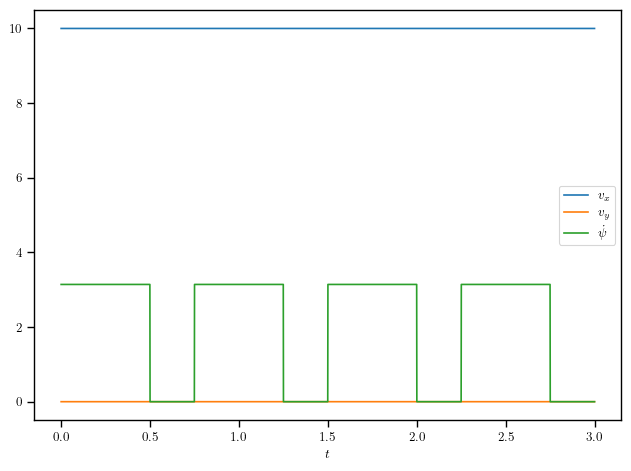

In [7]:
plt.plot(t_span,nu_t, label=[r"$v_x$",r"$v_y$",r"$\dot\psi$"])
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()
plt.savefig('nu.svg')

In [8]:
for i in range(t_span.shape[0]-1):
    trajectory[i+1] = ode.rk_one_step(kinematic_dynamic,trajectory[i],dt,nu_t[i])

/Users/muhammademzir/GitHub/Rigid_Body/venv/lib/python3.9/site-packages/BasicRigidBody-0.1-py3.9.egg/rigidbody/plotter.py:64: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/Users/muhammademzir/GitHub/Rigid_Body/venv/lib/python3.9/site-packages/BasicRigidBody-0.1-py3.9.egg/rigidbody/plotter.py:68: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


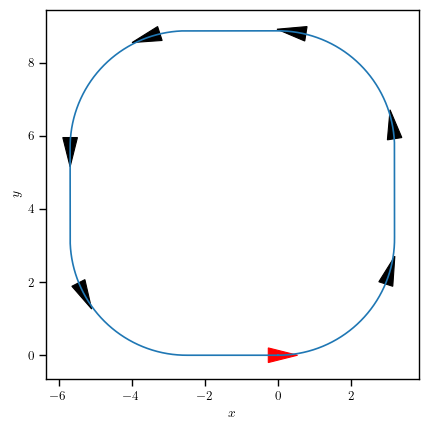

In [9]:
ax = plotter.two_d_trajectory_attitude_plot(trajectory,0.20,400,color="black",initial_color='red')
ax.set_aspect("equal")
# ax.scatter(trajectory[0,0],trajectory[0,1],s=30,color='red')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
plt.savefig('trajectory.svg')

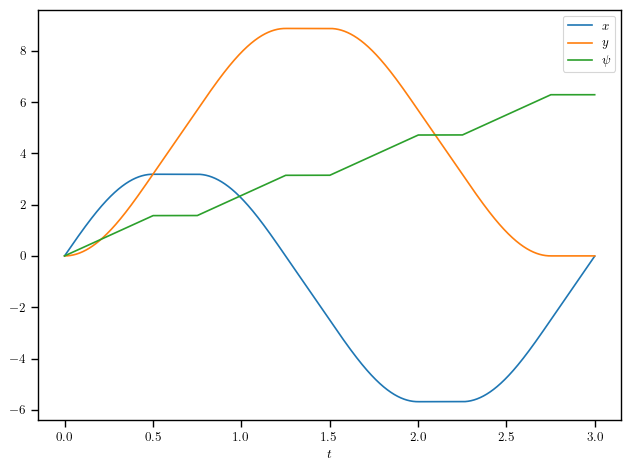

In [10]:
plt.plot(t_span,trajectory, label=[r"$x$",r"$y$",r"$\psi$"])
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()
plt.savefig('eta.svg')

In [11]:
desired_trajectory = trajectory[:,:2]

Create a controller that would allow the vehicle follows the desired trajectory.
Using a combination of two PI controllers, responsible for maintaining the speed and the angular velocity, we can write

$e = x_d(t)-x(t)$

$v_x(t) = K_{p,v} \|e(t)\|+ \int_0^t K_{i,v} \|e(s)\| ds$

$\psi_d = \text{atan2}(ey,ex)$

$\dot{\psi} = K_{p,\psi} (\psi_d(t)-\psi(t)) + \int_0^t K_{i,\psi} (\psi_d(s)-\psi(s)) ds$


In [12]:
controlled_trajectory = np.zeros_like(trajectory)
# controlled_trajectory[0] = np.array([0.0,2,-np.pi/2]) # this is easy
# controlled_trajectory[0] = np.array([-0.0,4.5,-np.pi/2]) # this is also fine
controlled_trajectory[0] = np.array([-1.0,4.5,-np.pi/2]) # this is also fine (still)
# controlled_trajectory[0] = np.array([-1.4,4.5,-np.pi/2]) # this is difficult

Propagate the dynamics with control

In [13]:
K_p_v = 1e1
K_i_v = 1e-2
K_p_psi = 5e1
K_i_psi = 2e-2

max_v_x = 1.5*v[0] #set maximum forward speed
max_psi_dot = 3*ones_portion[0] #set maximum angular speed
sum_norm_e = 0
sum_e_psi = 0
nu_hist = []
for i in range(t_span.shape[0]-1):
    e = desired_trajectory[i,:2] - controlled_trajectory[i,:2]
    norm_e = np.linalg.norm(e)
    v_x = K_p_v*norm_e + K_i_v*sum_norm_e
    v_x = np.minimum(v_x,max_v_x)
    sum_norm_e += norm_e
    psi_d = np.arctan2(e[1],e[0])

    #since psi_d can only be [0,2pi] this need to be handled properly
    if psi_d-controlled_trajectory[i,-1] < -np.pi:
        psi_d=psi_d+2*np.pi#*(controlled_trajectory[i,-1]//2*np.pi)
    elif psi_d-controlled_trajectory[i,-1] > np.pi:
        psi_d=psi_d-2*np.pi#*(controlled_trajectory[i,-1]//2*np.pi)
    else:
        psi_d = psi_d

    e_psi = (psi_d-controlled_trajectory[i,-1])
    sum_e_psi += e_psi
    psi_dot = K_p_psi*e_psi + K_i_psi*sum_e_psi
    psi_dot = np.clip(psi_dot,-max_psi_dot,max_psi_dot)
    nu_ = np.array([v_x,0.,psi_dot])
    nu_hist.append(nu_)
    controlled_trajectory[i+1] = ode.rk_one_step(kinematic_dynamic,controlled_trajectory[i],dt,nu_)
    # controlled_trajectory[i+1] = controlled_trajectory[i] + dt* kinematic_dynamic(controlled_trajectory[i],nu)
nu_hist = np.stack(nu_hist)

/Users/muhammademzir/GitHub/Rigid_Body/venv/lib/python3.9/site-packages/BasicRigidBody-0.1-py3.9.egg/rigidbody/plotter.py:64: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/Users/muhammademzir/GitHub/Rigid_Body/venv/lib/python3.9/site-packages/BasicRigidBody-0.1-py3.9.egg/rigidbody/plotter.py:68: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


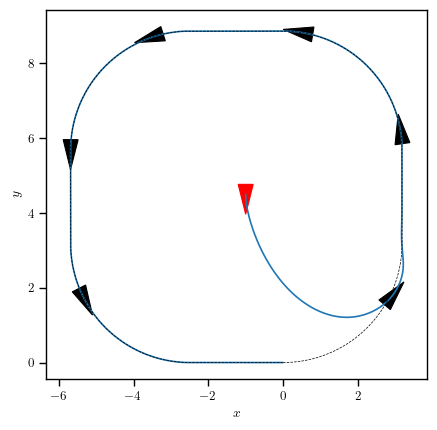

In [14]:
ax = plotter.two_d_trajectory_attitude_plot(controlled_trajectory,0.20,400,initial_color="red")
ax.plot(desired_trajectory[:,0],desired_trajectory[:,1],'--k',linewidth=0.5)
ax.set_aspect("equal")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
plt.savefig('controlled_trajectory.svg')

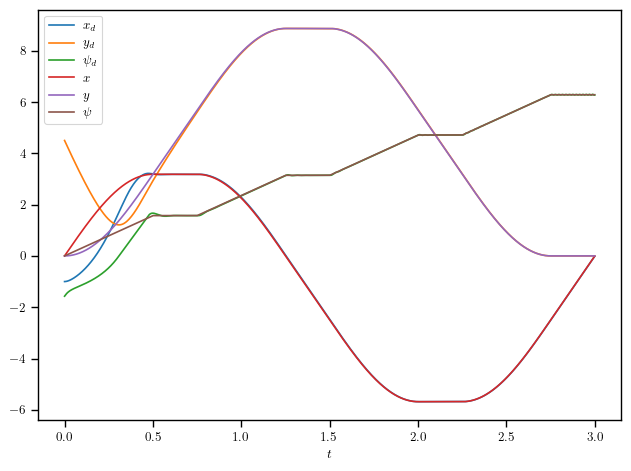

In [15]:
plt.plot(t_span,controlled_trajectory, label=[r"$x_d$",r"$y_d$",r"$\psi_d$"])
plt.plot(t_span,trajectory, label=[r"$x$",r"$y$",r"$\psi$"])
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()
plt.savefig('eta_controlled.svg')

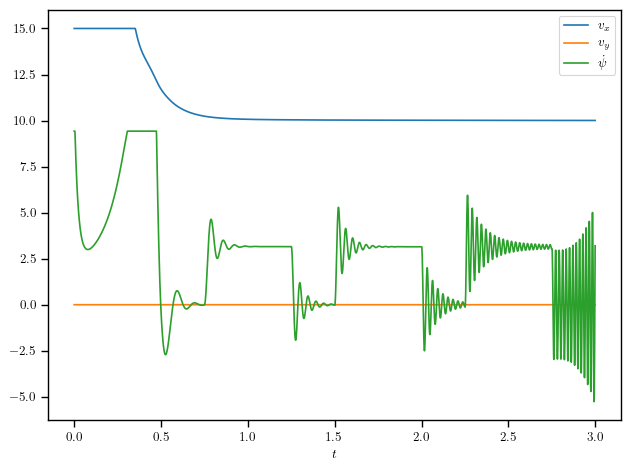

In [16]:
plt.plot(t_span[1:],nu_hist, label=[r"$v_x$",r"$v_y$",r"$\dot\psi$"])
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()